<font size = "5"/>**Предобработка русскоязычных данных для анализа когерентностей**<font/>

In [46]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import sklearn
from scipy.stats import ttest_ind, f_oneway
from mne_features.feature_extraction  import extract_features,FeatureExtractor
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity,plot_connectivity_circle
from scipy import signal
import pandas as pd
from sklearn.manifold import TSNE
#import pywt
import seaborn as sns
#from features_latest import gen_features
from itertools import combinations 

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import f_classif as F_test
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.decoding import CSP, Vectorizer
from mne.stats import permutation_cluster_test
from mne.stats import spatio_temporal_cluster_test, combine_adjacency
from mne.channels import find_ch_adjacency
from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet, tfr_multitaper
from mne.export import export_epochs
import smote_variants
#import mne_icalabel as isa

import sys

In [2]:
%matplotlib widget

In [3]:
import matplotlib
matplotlib.get_backend()
matplotlib.use('Agg',force=True)

In [4]:
def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
    return list

In [5]:
def read_data(path,filter = False):
    """
    input: data path, if filter parameter is True, than bandpass filter 0.1 - 50 Hz is applied 
    output: raw mne object; event numpy array; events descriptions as dict;
    raw data as numpy array.
    """
    raw = mne.io.read_raw_edf(path, preload=False)
    if filter == True:
        raw.filter(l_freq=1, h_freq=70)
    annotat = mne.events_from_annotations(raw)
    event_np = annotat[0]
    event_desc = annotat[1]
    # data = raw.get_data()
    data = np.array([])
    return raw,event_np,event_desc, data

# Загрузим данные русскоязычных

In [6]:
mainPath = r'/home/dataFolder/DataPrior/Russian/raw'
allData = []
loadR = [0,8]
for i in range(loadR[0],loadR[1]):
    raw, event_np, event_desc, data = read_data(mainPath + '/' + 'sub-{}'.format(i) + '/' + 'sub-{}.edf'.format(i), filter = False)
    allData.append([raw, event_np, event_desc, data])

Extracting EDF parameters from /home/dataFolder/DataPrior/Russian/raw/sub-0/sub-0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['10:54:20', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'NEXT1', 'NEXT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Extracting EDF parameters from /home/dataFolder/DataPrior/Russian/raw/sub-1/sub-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['16:05:07', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'NEXT1', 'NEXT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Extracting EDF parameters from /home/dataFolder/DataPrior/Russian/raw/sub-2/sub-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['12:56:00', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'G

In [7]:
#здесь данные с разными методиками, явно испорченные записи или записи со шкалящим альфа ритмом
#я изначально исключил. Во ключенных данных расхождения видов меток между некоторыми записями,
#надо готовить данные отдельно

In [8]:
for ev in allData:
    print(np.where(ev[1][:,2] == 8)[0].shape)

(16,)
(3,)
(4,)
(23,)
(21,)
(89,)
(31,)
(4,)


In [9]:
#видим, что записи 1,2 и 7 имеют малое количество меток для ГО
long_recs = [1,2,7]
bad_recs = [4]

In [10]:
#немного замарфетим чтобы код от испанцев подошел
rawData = [data[0] for data in allData]
anats = [[data[1], data[2]] for data in allData]
rawData[5].drop_channels([ 'B1+', 'B1-'])
# for ind, raw in enumerate(rawData):
#     if ind == 6:
#         continue
#     rawData[ind].drop_channels(['FCz', 'Oz', 'T7'])

Measurement date,"September 18, 2023 12:16:27 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,37 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,70.00 Hz


In [11]:
#если посмотреть записи, многие из них очень плохого качетва, надо что-то делать 
#например для начала поставить фильтр
for raw in rawData:
    raw.load_data()
    raw.filter(l_freq=1, h_freq=70, verbose = 0)
    raw.notch_filter(50, verbose = 0)

Reading 0 ... 2092499  =      0.000 ...  4184.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Reading 0 ... 1639499  =      0.000 ...  3278.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Reading 0 ... 1408999  =      0.000 ...  2817.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Reading 0 ... 1520499  =      0.000 ...  3040.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Reading 0 ... 1956499  =      0.000 ...  3912.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Reading 0 ... 2339499  =      0.000 ...  4678.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Reading 0 ... 992749  =      0.000 ...  3970.996 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Reading 0 ... 1452999  =      0.000 ...  2905.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


In [13]:
#что дальше? надо разложтить на независимые компоненты и посмотреть их по каждый записи
icas = {}
for ind, raw in enumerate(rawData):
    icas[ind] = mne.preprocessing.ICA(n_components=35, max_iter="auto", random_state=97,method='fastica')
    icas[ind].fit(raw)

Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 61.3s.
Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 28.3s.
Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 19.6s.
Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 51.4s.
Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 54.2s.
Fitting ICA to data using 37 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 78.2s.
Fitting ICA to data using 35 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 34.3s.
Fitting ICA to data 

In [14]:
icas

{0: <ICA | raw data decomposition, method: fastica (fit in 73 iterations on 2092500 samples), 35 ICA components (37 PCA components available), channel types: eeg, no sources marked for exclusion>,
 1: <ICA | raw data decomposition, method: fastica (fit in 39 iterations on 1639500 samples), 35 ICA components (37 PCA components available), channel types: eeg, no sources marked for exclusion>,
 2: <ICA | raw data decomposition, method: fastica (fit in 31 iterations on 1409000 samples), 35 ICA components (37 PCA components available), channel types: eeg, no sources marked for exclusion>,
 3: <ICA | raw data decomposition, method: fastica (fit in 86 iterations on 1520500 samples), 35 ICA components (37 PCA components available), channel types: eeg, no sources marked for exclusion>,
 4: <ICA | raw data decomposition, method: fastica (fit in 67 iterations on 1956500 samples), 35 ICA components (37 PCA components available), channel types: eeg, no sources marked for exclusion>,
 5: <ICA | raw 

Creating RawArray with float64 data, n_channels=35, n_times=1453000
    Range : 0 ... 1452999 =      0.000 ...  2905.998 secs
Ready.


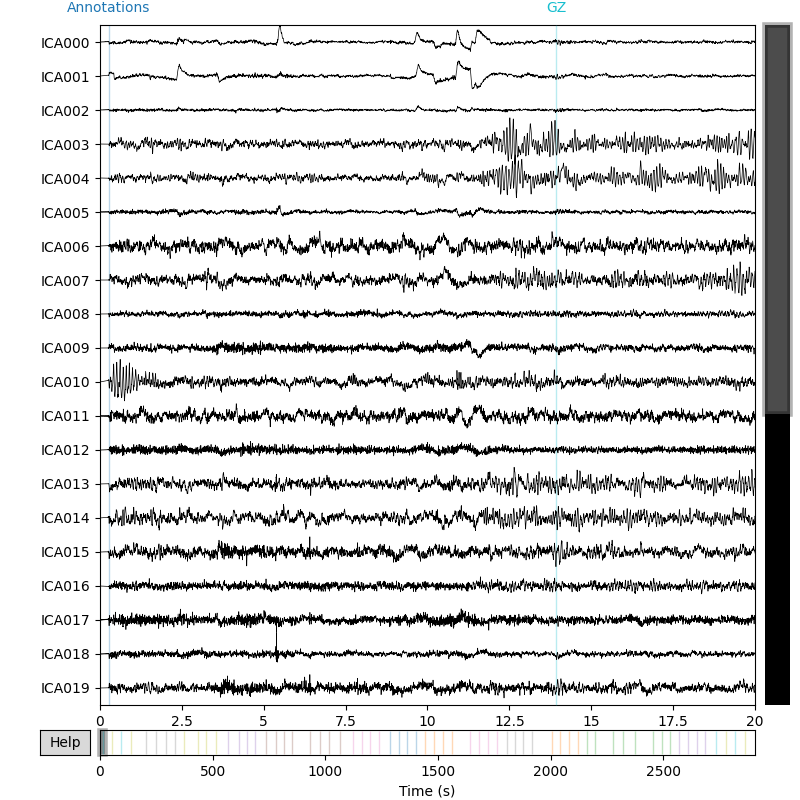

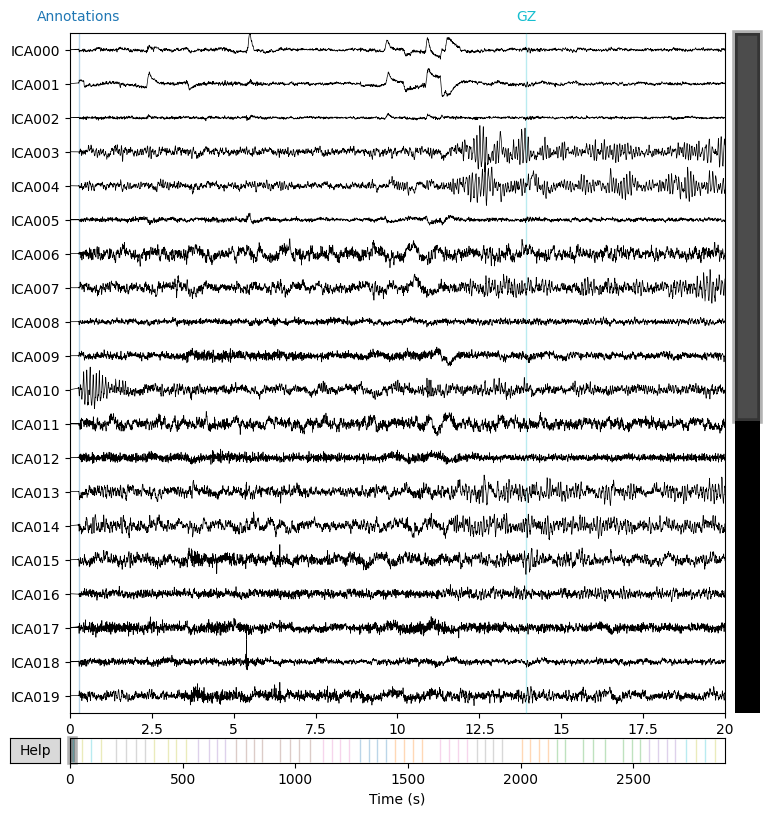

In [19]:
#вручную смотрим компоненты, отбираем плохие
icas[7].plot_sources(rawData[7])

In [15]:
#запишем индексы плохих в словарь
exc = {
    6: [1,27,26,29],
    5: [0,2,32],
    3: [0,32,21,24,27,17],
    0: [0,5],
    1: [0],
    2: [0,1],
    7: [0,1]
}
#необходимо исключить их из дальнейшего анализа
for key in icas.keys():
    if key in bad_recs:
        continue
    icas[key].exclude = exc[key]
    icas[key].apply(rawData[key])

Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 2 ICA components
    Projecting back using 37 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 1 ICA component
    Projecting back using 37 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 2 ICA components
    Projecting back using 37 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 6 ICA components
    Projecting back using 37 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 3 ICA components
    Projecting back using 37 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 4 ICA components
    Projecting back using 35 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing ou

In [16]:
#вроде большее количество дефетов удалили из записей (наверное, я не спец в этом)

In [17]:
#список для коротких меток
inners = ['BACK2','DOWN2','FORWARD2','LEFT2','RIGHT2','UP2','GO']

In [18]:
#crop the recodring by the real borders of each word trials
crops = {}
fixed = {}
for ind, sub in enumerate(rawData):
    sfreq = sub.info['sfreq']
    if ind in long_recs or ind in bad_recs:
        continue
    cur = {}
    fix = {}
    for word in inners:
        alls = anats[ind][0][np.where(anats[ind][0][:,2] == anats[ind][1][word])[0], 0]
        #start and end of full segment
        start, end = np.array([alls[0]]) , np.array([alls[-1]])
        #starts and ends of subsegments (if there are gaps of longer than 6 sec)
        med_st = alls[np.where((np.diff(alls) // sfreq) >= 6)]
        med_en = alls[np.where((np.diff(alls) // sfreq) >= 6)[0] + 1]
        #all in one
        united = np.sort(np.concatenate([start,med_st, med_en, end]))
        united  = united.reshape(united.shape[0] // 2, 2)
        #iterate over segment indicies
        cr = []
        fi = []
        for st_en in united:
            seg = sub.copy().crop(tmin = st_en[0] // sfreq, tmax = st_en[1] // sfreq)
            if len(seg) // sfreq > 15:
                fi.append(mne.make_fixed_length_epochs(seg, duration = 5.0, overlap = 0.5, verbose = 0))
                cr.append(seg)
        #collect by word and subject
        cur[word] = cr
        fix[word] = fi
    crops[ind] = cur
    fixed[ind] = fix

In [19]:
#поработаем с длинными метками
for ind, sub in enumerate(rawData):
    if ind not in long_recs:
        continue
    sfreq = sub.info['sfreq']
    cur = {}
    fix = {}
    for words in inners:
        gap = 20
        if words == 'GO':
            gap = 35
        rList = []
        fList = []
        marks = np.where(anats[ind][0][:,2] == anats[ind][1][words])[0]
        for mark in marks:
            start = anats[ind][0][mark,0] // sfreq
            end = start + gap
            tempRaw = sub.copy().crop(tmin = start, tmax = end)
            rList.append(tempRaw)
            fList.append(mne.make_fixed_length_epochs(tempRaw, duration = 5.0, overlap = 0.5, verbose = 0))
        cur[words] = rList
        fix[words] = fList
    crops[ind] = cur
    fixed[ind] = fix

In [20]:
#можно считать когерентность по старым лекалаам
allCoh = {}
for sub in fixed.keys():
    sfreq = rawData[sub].info['sfreq']
    print('Calculating coherence for subject {}'.format(sub))
    labCoh = {}
    for word in fixed[sub].keys():
        print('Word {}'.format(word))
        uniq_ch_ind = list(combinations(range(len(rawData[sub].ch_names)), 2))
        crops = fixed[sub][word]
        cropCoh = []
        for crop in crops:
            data = crop.get_data()
            epoCoh = []
            for epoch in data:
                pairCoh = []
                for pair in uniq_ch_ind:
                    f, Cxy = signal.coherence(epoch[pair[0],:], epoch[pair[1],:], fs = sfreq, nperseg = sfreq)
                    Cxy = np.array([Cxy[np.where(f<70)[0]]])
                    pairCoh.append(Cxy)
                pairCoh = np.expand_dims(np.concatenate(pairCoh, axis = 0), axis = 0)
                epoCoh.append(pairCoh)
            epoCoh = np.concatenate(epoCoh, axis = 0)
            cropCoh.append(epoCoh)
        labCoh[word] = cropCoh
    allCoh[sub] = labCoh

Calculating coherence for subject 0
Word BACK2
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 3 events and 2500 original time points ...
0 bad epochs dropped
Word DOWN2
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 5 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 7 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Word FORWARD2
Using data from preloaded Raw for 6 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 5 events and

In [89]:
statBand = (55,65)
pThres = 0.001
pis = {}
for sub in allCoh.keys():
    ch_shape = allCoh[sub]['GO'][0].shape[1]
    goSt = np.mean(np.concatenate(allCoh[sub]['GO'], axis = 0)[:,:,statBand[0]:statBand[1]], axis = 2)
    wordSt = np.zeros((1,ch_shape,70))
    for word in inners:
        if word == 'GO':
            continue
        curW = np.concatenate(allCoh[sub][word], axis = 0)
        wordSt = np.append(wordSt, curW, axis = 0)
    wordSt = np.mean(wordSt[1:,:,statBand[0]:statBand[1]], axis = 2)
    t, p = f_oneway(wordSt, goSt, axis = 0)
    pis[sub] = np.array([p])
#pis = np.concatenate(pis, axis = 0)
#get indices of p value lower than threshold

newp = {}
for sub in pis.keys():
    curInd = np.where(pis[sub] < pThres)
    curP = np.zeros((pis[sub].shape))
    curP[curInd] = 1
    newp[sub] = curP

In [23]:
print('Percent of channels with significant difference for ...')
for ind, sub in enumerate(pis):
    if ind == 6:
        continue
    percent = np.argwhere(sub == 1).shape[0]/ sub.shape[0]
    print('sub-{}'.format(ind),round(percent * 100,2),'%')

Percent of channels with significant difference for ...
sub-0 40.69 %
sub-1 4.95 %
sub-2 35.29 %
sub-3 49.4 %
sub-4 34.68 %
sub-5 13.96 %


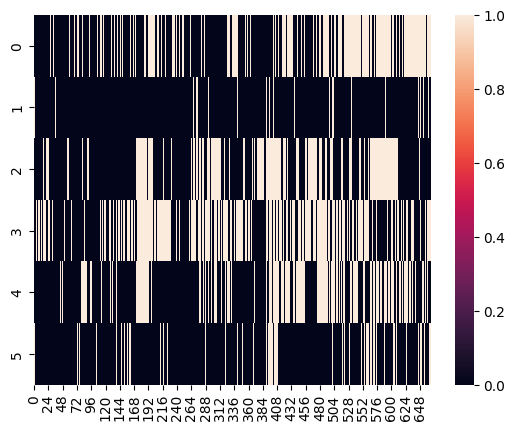

In [30]:
sns.heatmap(pis)
plt.show()

In [92]:
import logging
logger = logging.getLogger('smote_variants')
logger.disabled = True

In [98]:
#classification trials
accuracies = []
overSamp = True
getInitLab = True
#pal = sns.color_palette("hls", 7)
saveTrain = True
Xs = []
ys = []
confusions = []
for sub in allCoh.keys():
    clf = Pipeline([
        ('scaler', StandardScaler()),
        #('svm', SVC(kernel = 'rbf', gamma = 'scale')),
        #('pca', PCA(n_components = 4)),
        ('svm', SVC(kernel = 'linear', decision_function_shape='ovr'))
    ])
   
    ch_ind = np.where(newp[sub][0,:] == 1)[0]
    X_go = np.mean(np.concatenate(allCoh[sub]['GO'], axis = 0)[:,ch_ind,55:65], axis = 2)
    y_go = np.ones((X_go.shape[0]))

    initY = np.array([])
    X_word = np.zeros((1,pis[sub].shape[1],70))
    for word in inners:
        if word == 'GO':
            continue
        curW = np.concatenate(allCoh[sub][word], axis = 0)
        X_word = np.append(X_word, curW, axis = 0)
        if getInitLab == True:
            ind = anats[sub][0][np.where(anats[sub][0][:,2] == anats[sub][1][word])[0], 2][0]
            curY = np.full(curW.shape[0], ind)
            initY = np.append(initY, curY)
            
    X_word = np.mean(X_word[1:,ch_ind,55:65], axis = 2)
    
    if getInitLab == True:
        y_word = initY
    else:
        y_word = np.zeros((X_word.shape[0]))

    X = np.concatenate([X_go, X_word], axis = 0)
    y = np.concatenate([y_go, y_word])

    if overSamp == True:
        over_sampler = smote_variants.Supervised_SMOTE()
        #over_sampler = smote_variants.polynom_fit_SMOTE_bus()
        X, y = over_sampler.sample(X, y)

    if saveTrain == True:
        Xs.append(X)
        ys.append(y)
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.33)

    print('Subject {}'.format(sub))
    scores = cross_val_score(clf, X, y, scoring = 'accuracy')
    print(scores,' ','{}'.format(round(np.mean(scores), 3) * 100),'%')
    
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    accuracies.append(accuracy_score(test_y, y_pred))
    confusions.append(confusion_matrix(test_y, y_pred))
    print(confusion_matrix(test_y, y_pred))
    print('---------------------------------------------------------')

Subject 0
[0.75862069 0.79310345 0.78571429 0.82142857 0.82142857]   79.60000000000001 %
[[5 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 8 2 1 0 0]
 [0 0 0 6 1 0 0]
 [0 0 0 1 5 0 0]
 [0 0 1 0 0 6 0]
 [0 0 0 0 0 0 8]]
---------------------------------------------------------
Subject 3
[0.80769231 0.57692308 0.65384615 0.72       0.56      ]   66.4 %
[[5 0 0 1 0 0 0]
 [0 9 0 3 0 0 0]
 [0 0 6 0 0 0 0]
 [0 2 0 2 1 0 0]
 [0 0 0 2 1 0 0]
 [2 0 0 0 0 3 0]
 [0 0 3 0 0 0 3]]
---------------------------------------------------------
Subject 5
[0.78       0.86       0.74       0.74       0.71428571]   76.7 %
[[10  0  0  0  0  0  0]
 [ 0 13  0  0  2  0  0]
 [ 0  0  7  0  0  1  2]
 [ 0  0  0 10  0  0  0]
 [ 0  3  0  0 10  0  0]
 [ 0  0  8  0  0  4  2]
 [ 0  0  2  0  0  0  9]]
---------------------------------------------------------
Subject 6
[0.6875     0.85416667 0.83333333 0.77083333 0.66666667]   76.2 %
[[11  0  0  0  0  0  0]
 [ 0 10  1  2  0  0  0]
 [ 1  0  9  0  0  1  1]
 [ 0  3  0  9  0  0  0]
 [ 0

In [96]:
accuracies

[0.8723404255319149,
 0.5813953488372093,
 0.8554216867469879,
 0.8125,
 0.9512195121951219,
 0.7111111111111111,
 0.8222222222222222]

In [97]:
scores

array([0.60714286, 0.81481481, 0.88888889, 0.7037037 , 0.77777778])